In [1]:
!pip install kaggle

In [1]:
! mkdir ~/.kaggle

In [2]:
! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d l33tc0d3r/indian-food-classification

 99% 1.47G/1.48G [00:10<00:00, 174MB/s]
100% 1.48G/1.48G [00:10<00:00, 150MB/s]


In [5]:
! unzip indian-food-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: Food Classification/chapati/253.jpg  
  inflating: Food Classification/chapati/254.jpg  
  inflating: Food Classification/chapati/255.jpg  
  inflating: Food Classification/chapati/256.jpg  
  inflating: Food Classification/chapati/257.jpg  
  inflating: Food Classification/chapati/258.jpg  
  inflating: Food Classification/chapati/259.jpg  
  inflating: Food Classification/chapati/260.jpg  
  inflating: Food Classification/chapati/261.jpg  
  inflating: Food Classification/chapati/262.jpg  
  inflating: Food Classification/chapati/263.jpg  
  inflating: Food Classification/chapati/264.jpg  
  inflating: Food Classification/chapati/265.jpg  
  inflating: Food Classification/chapati/266.jpg  
  inflating: Food Classification/chapati/267.jpg  
  inflating: Food Classification/chapati/268.jpg  
  inflating: Food Classification/chapati/269.jpg  
  inflating: Food Classification/chapati/270.jpg  
  inflating: Food Classificatio

In [6]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf

from sklearn.metrics import confusion_matrix ,classification_report

In [7]:
image_dir=Path('/content/Food Classification')
filepaths=list(image_dir.glob(r'**/*.jpg'))
labels=list(map(lambda x:os.path.split(os.path.split(x)[0])[1],filepaths))
filepaths=pd.Series(filepaths,name='Filepaths').astype(str)
labels=pd.Series(labels,name='Label')
images=pd.concat([filepaths,labels],axis=1)
category_samples=[]

for category in images['Label'].unique():
    category_slices=images.query('Label==@category')
    category_samples.append(category_slices.sample(frac=1,random_state=1))
image_df=pd.concat(category_samples,axis=0).sample(frac=1.0,random_state=1).reset_index(drop=True)
image_df

,Filepaths,Label
0,/content/Food Classification/kulfi/221.jpg,kulfi
1,/content/Food Classification/chapati/375.jpg,chapati
2,/content/Food Classification/chole_bhature/279...,chole_bhature
3,/content/Food Classification/chai/136.jpg,chai
4,/content/Food Classification/butter_naan/325.jpg,butter_naan
...,...,...
6248,/content/Food Classification/burger/236.jpg,burger
6249,/content/Food Classification/butter_naan/075.jpg,butter_naan
6250,/content/Food Classification/jalebi/061.jpg,jalebi
6251,/content/Food Classification/dal_makhani/110.jpg,dal_makhani


In [8]:
image_df['Label'].value_counts()

chapati          413
kadai_paneer     412
chole_bhature    410
chai             381
fried_rice       353
pav_bhaji        353
butter_naan      328
momos            319
dal_makhani      319
masala_dosa      311
burger           309
idli             306
kaathi_rolls     293
jalebi           293
dhokla           289
pakode           278
samosa           261
pizza            261
kulfi            234
paani_puri       130
Name: Label, dtype: int64

In [9]:
train_df,test_df=train_test_split(image_df,train_size=0.7,shuffle=True,random_state=1)
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3502 validated image filenames belonging to 20 classes.
Found 875 validated image filenames belonging to 20 classes.
Found 1876 validated image filenames belonging to 20 classes.


In [10]:
pretrained_model=tf.keras.applications.MobileNetV2(
     input_shape=(224,224,3),
     include_top=False,
     weights='imagenet',
     pooling='avg'

)
pretrained_model.trainable=False

9406464/9406464 [==============================] - 0s 0us/step


In [11]:
inputs=pretrained_model.input
x=tf.keras.layers.Dense(128,activation='relu')(pretrained_model.output)
x=tf.keras.layers.Dense(128,activation='relu')(x)
outputs=tf.keras.layers.Dense(20,activation='softmax')(x)
model=tf.keras.Model(inputs,outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [12]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=7,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/7
110/110 [==============================] - 275s 2s/step - loss: 1.4309 - accuracy: 0.5974 - val_loss: 0.8631 - val_accuracy: 0.7566
Epoch 2/7
110/110 [==============================] - 292s 3s/step - loss: 0.5886 - accuracy: 0.8238 - val_loss: 0.7768 - val_accuracy: 0.7749
Epoch 3/7
110/110 [==============================] - 266s 2s/step - loss: 0.3520 - accuracy: 0.8975 - val_loss: 0.7284 - val_accuracy: 0.7954
Epoch 4/7
110/110 [==============================] - 246s 2s/step - loss: 0.2295 - accuracy: 0.9366 - val_loss: 0.7834 - val_accuracy: 0.7863
Epoch 5/7
110/110 [==============================] - 274s 2s/step - loss: 0.1444 - accuracy: 0.9589 - val_loss: 0.7548 - val_accuracy: 0.8057
Epoch 6/7
110/110 [==============================] - 280s 3s/step - loss: 0.0673 - accuracy: 0.9894 - val_loss: 0.8025 - val_accuracy: 0.7977


In [13]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 79.26%


59/59 [==============================] - 97s 2s/step


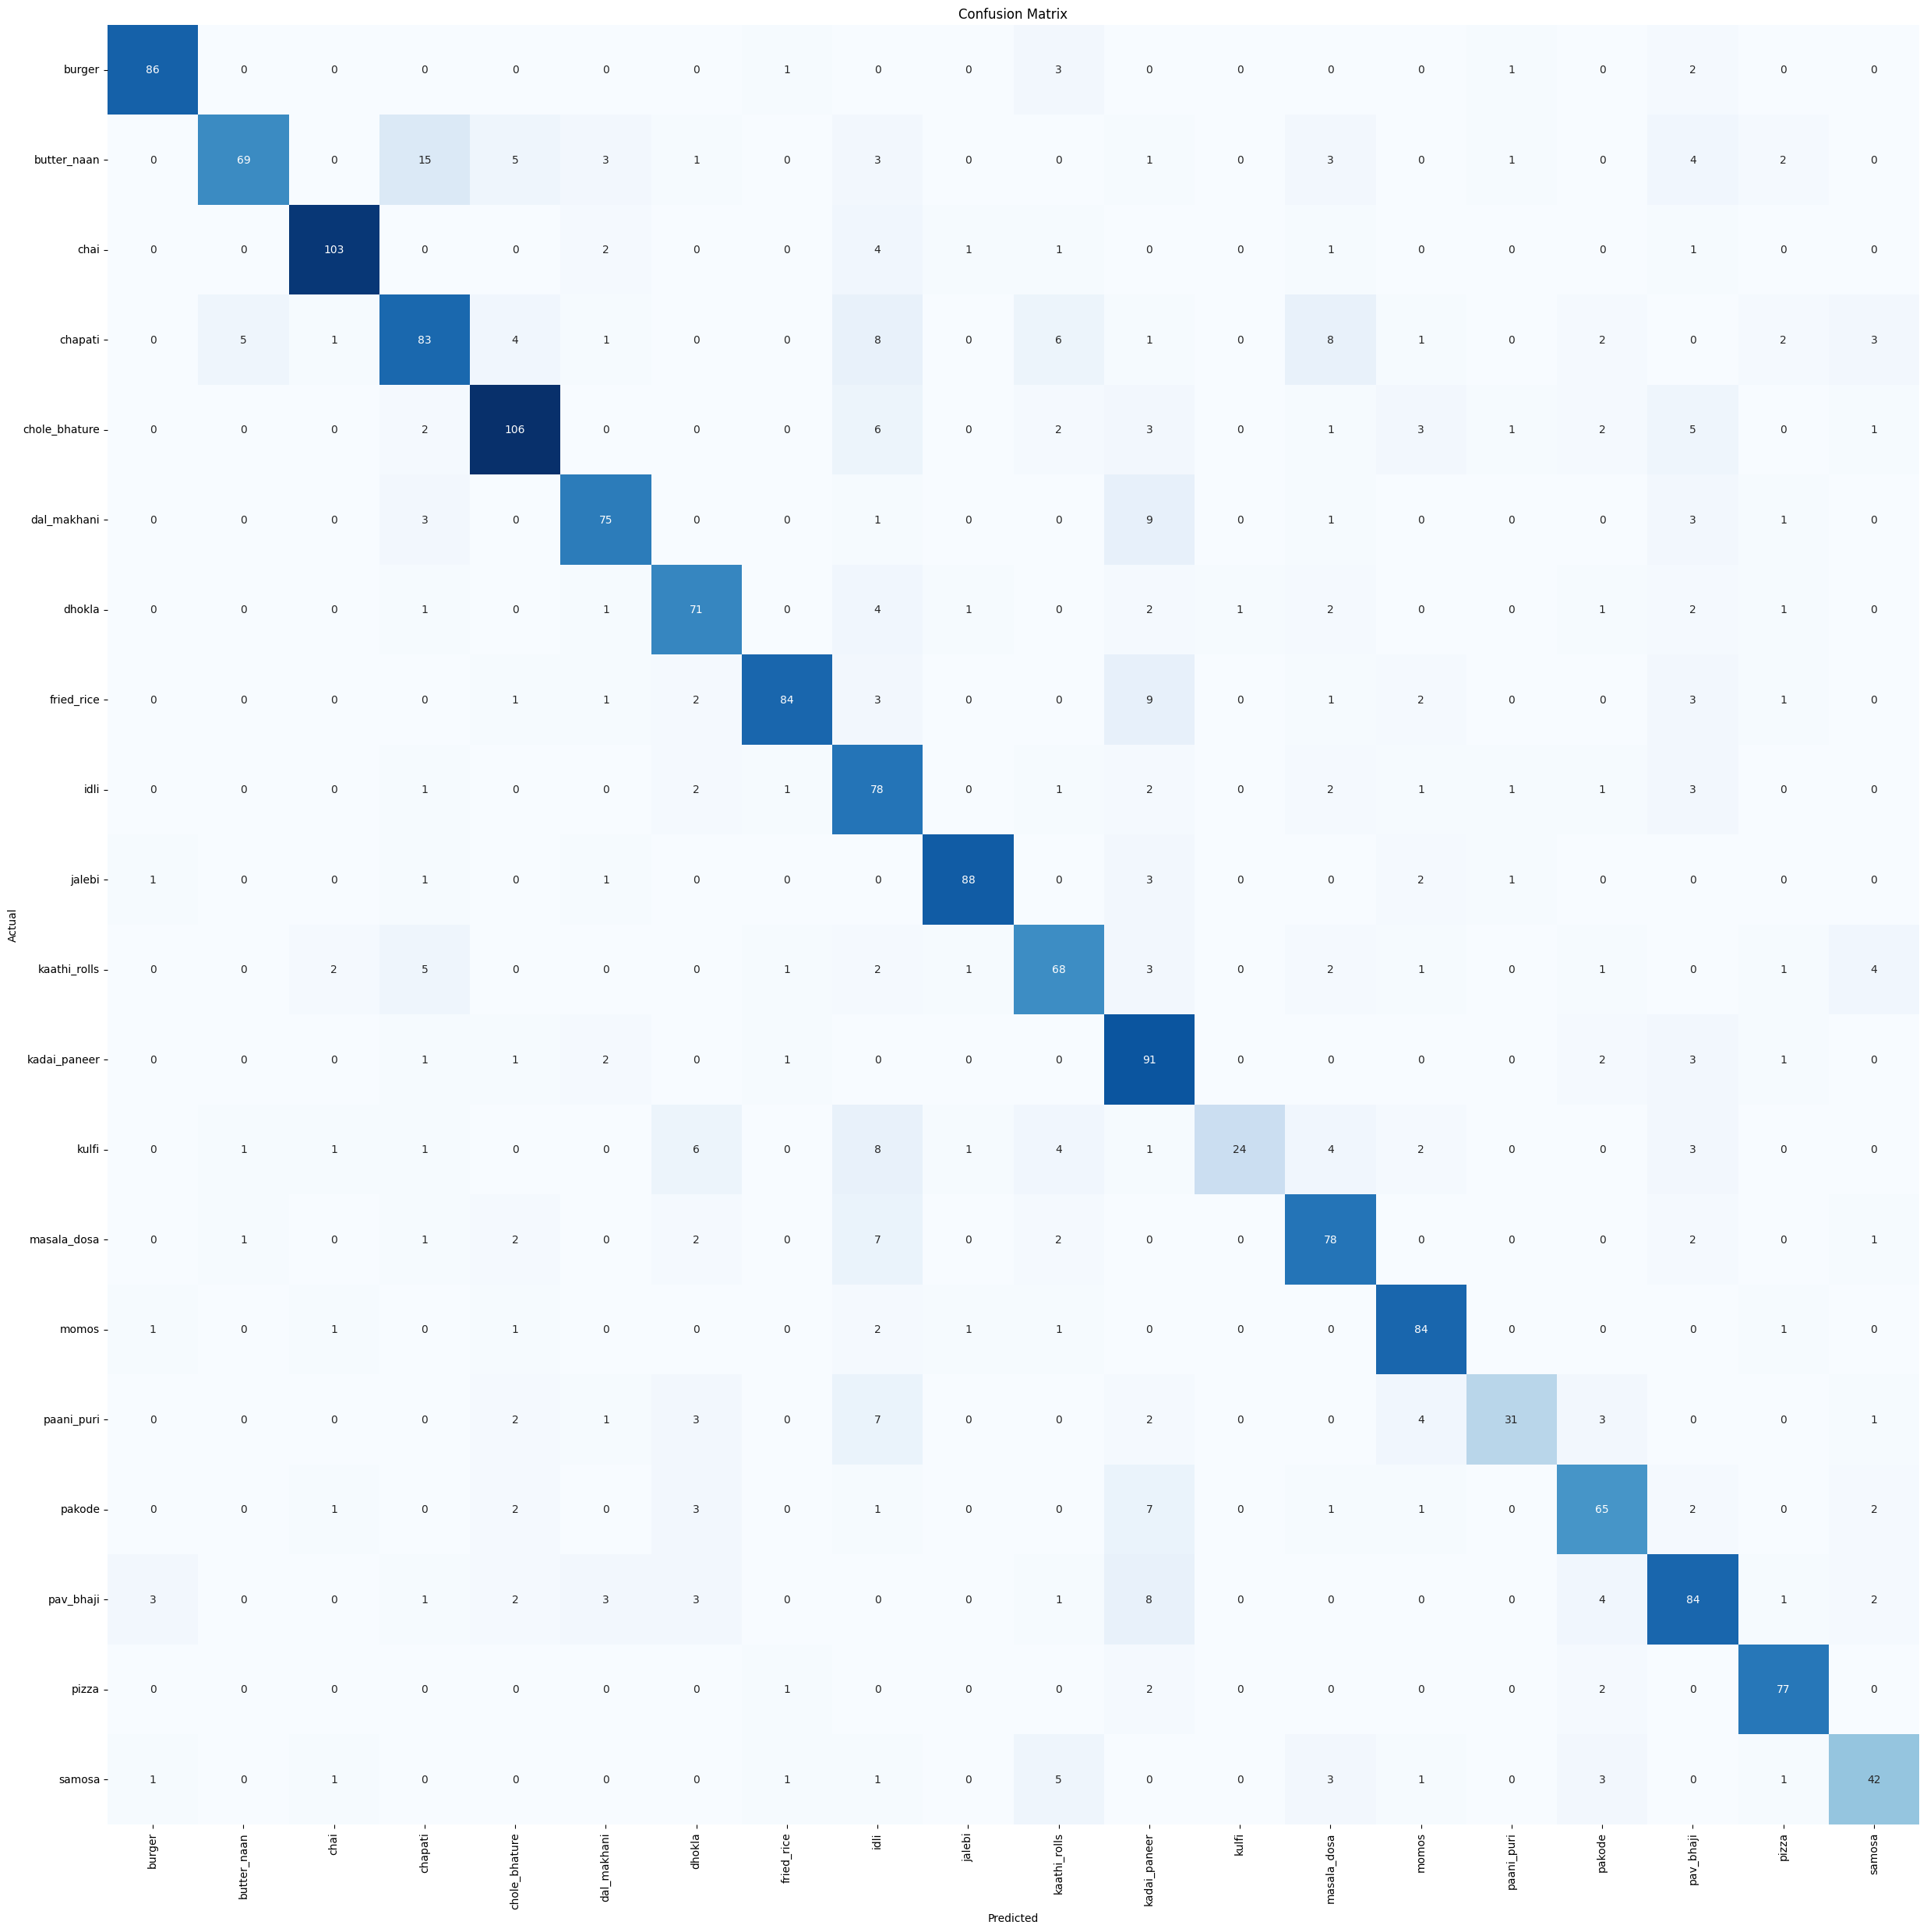

In [14]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(20) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(20) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [15]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                precision    recall  f1-score   support

       burger       0.93      0.92      0.93        93
  butter_naan       0.91      0.64      0.75       107
         chai       0.94      0.91      0.92       113
      chapati       0.72      0.66      0.69       125
chole_bhature       0.84      0.80      0.82       132
  dal_makhani       0.83      0.81      0.82        93
       dhokla       0.76      0.82      0.79        87
   fried_rice       0.93      0.79      0.85       107
         idli       0.58      0.84      0.68        93
       jalebi       0.95      0.91      0.93        97
 kaathi_rolls       0.72      0.75      0.74        91
 kadai_paneer       0.63      0.89      0.74       102
        kulfi       0.96      0.43      0.59        56
  masala_dosa       0.73      0.81      0.77        96
        momos       0.82      0.91      0.87        92
   paani_puri       0.86      0.57      0.69        54
       pakode    

In [16]:
model.save('foody.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [23]:
unique_labels = set(labels)
print("Class Labels:", unique_labels)

Class Labels: {'burger', 'dal_makhani', 'jalebi', 'pakode', 'pav_bhaji', 'kadai_paneer', 'momos', 'samosa', 'masala_dosa', 'kaathi_rolls', 'butter_naan', 'pizza', 'chai', 'kulfi', 'dhokla', 'paani_puri', 'idli', 'fried_rice', 'chole_bhature', 'chapati'}
